In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [30]:
data = pd.read_csv("./set4.txt", sep = ' ', index_col=0, header=None)[1].values
data[:10]

array(['R', 'L', 'R', 'L', 'R', 'L', 'L', 'L', 'L', 'R'], dtype=object)

In [44]:
from collections import Counter

c = Counter(data)
c

Counter({'L': 400, 'R': 400})

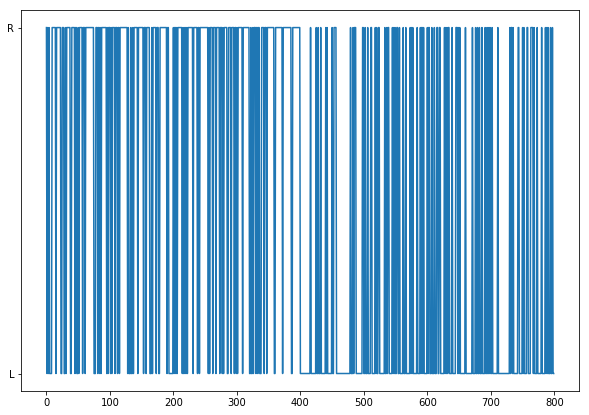

In [47]:
plt.figure(figsize=(10,7))
plt.plot(data)
plt.show()

In [76]:
###########################
# data structures:
#
# numstates: number of states. we omit start and end state here, and assume equal probability of starting in either state.
#
# emission probabilities: numpy matrix of shape (N, |V|) (where |V| is the size of the vocabulary)
# where entry (j, o) has emis_j(o).
#
# transition probablities: numpy matrix of shape (N, N) where entry (i, j) has trans(i, j).
#
# forward and backward probabilities: numpy matrix of shape (N, T) where entry (s, t) has forward probability
# for state s and observation t

################
# computing forward and backward probabilities
# forward:
# alpha_t(j) = P(o1, ..., ot, qt = j | HMM)
# forward function: returns numpy matrix of size (N, T)

from typing import List, Dict
import numpy as np


class MyLittleHMM:
    def __init__(self, numstates: int, observations_vocab: Dict[str, int]):
        self.numstates = numstates
        self.vocabsize = len(observations_vocab)
        self.observations_vocab = observations_vocab

        self.transition = self._random_mtx_init(numstates, numstates)
        self.emission = self._random_mtx_init(numstates, self.vocabsize)
        self.init_probs = self._random_mtx_init(1, numstates)

    @staticmethod
    def _random_mtx_init(nrows, ncols) -> np.ndarray:
        """
        :param nrows:
        :param ncols:
        :return: just return random matrix with sum of each row = 1
                (stochastic matrices)
        """
        if nrows == 1:
            tmp = np.random.rand(ncols)
            return tmp / sum(tmp)
        else:
            mtx = np.zeros((nrows, ncols))
            for i in range(nrows):
                unnormalized = np.random.rand(ncols)
                mtx[i] = unnormalized / sum(unnormalized)
            return mtx
        
        
    def print_all(self):
        print("TRANSITION MTX:")
        print(self.transition)
        print("\nEMISSION MTX:")
        print(self.emission)
        print("\nINITIAL_PROBS:")
        print(self.init_probs)
        
        
    def forward(self, observations: List[str]) -> np.ndarray:
        """
        :param observations:
        :return: matrix of size [NxT]
        """

        forwardmatrix = np.zeros((self.numstates, len(observations)))

        # initialization
        obs_index = self.observations_vocab[observations[0]]
        for s in range(self.numstates):
            forwardmatrix[s, 0] = self.init_probs[s] * self.emission[s, obs_index]

        # dynamically calculate probs for each time stamp
        for t in range(1, len(observations)):
            obs_index = self.observations_vocab[observations[t]]
            for s in range(self.numstates):
                forwardmatrix[s, t] = self.emission[s, obs_index] * sum(
                    [forwardmatrix[s2, t - 1] * self.transition[s2, s] \
                     for s2 in range(self.numstates)])
        return forwardmatrix

    def backward(self, observations: List[str]) -> np.ndarray:
        backwardmatrix = np.zeros((self.numstates, len(observations)))

        # initialization
        for s in range(self.numstates):
            backwardmatrix[s, len(observations) - 1] = 1.0

        # dynamically calculate probs for each time stamp
        for t in range(len(observations) - 2, -1, -1):
            obs_index = self.observations_vocab[observations[t + 1]]
            for s in range(self.numstates):
                backwardmatrix[s, t] = sum([self.transition[s, s2] * self.emission[s2, obs_index] *
                                            backwardmatrix[s2, t + 1] for s2 in range(self.numstates)])

        return backwardmatrix

    ####
    # expectation step:
    # re-estimate xi_t(i, j) and gamma_t(j)
    # returns two things:
    # - gamma is a (N, T) numpy matrix
    # - xi is a list of T numpy matrices of size (N, N)
    def expectation(self, observations, forward_probs, backward_probs):
        # denominator: P(O | HMM)
        p_o_given_hmm = sum([forward_probs[s_i, len(observations) - 1] for s_i in range(self.numstates)])

        # computing xi
        xi = []
        for t in range(len(observations) - 1):
            obs_index = self.observations_vocab[observations[t + 1]]

            xi_t = np.zeros((self.numstates, self.numstates))

            for s_i in range(self.numstates):
                for s_j in range(self.numstates):
                    xi_t[s_i, s_j] = (forward_probs[s_i, t] * self.transition[s_i, s_j] * self.emission[s_j, obs_index]
                                      * backward_probs[s_j, t + 1]) / p_o_given_hmm
            xi.append(xi_t)

        # computing gamma
        gamma = np.zeros((self.numstates + 2, len(observations)))
        for t in range(len(observations) - 1):
            for s_i in range(self.numstates):
                gamma[s_i, t] = sum([xi[t][s_i, s_j] for s_j in range(self.numstates)])
        for s_j in range(self.numstates):
            gamma[s_j, len(observations) - 1] = sum([xi[t][s_i, s_j] for s_i in range(self.numstates)])

        return gamma, xi

    ###
    # maximization step:
    # re-estimate trans, emis based on gamma, xi
    # returns:
    # - initialprob
    # - trans
    # - emis
    def maximization(self, observations, gamma, xi):
        # re-estimate initial probabilities
        initialprob = np.array([gamma[s_i, 0] for s_i in range(self.numstates)])

        # re-estimate emission probabilities
        emis = np.zeros((self.numstates, self.vocabsize))

        for s in range(self.numstates):
            denominator = sum([gamma[s, t] for t in range(len(observations))])
            for vocab_item, obs_index in self.observations_vocab.items():
                emis[s, obs_index] = sum(
                    [gamma[s, t] for t in range(len(observations)) if observations[t] == vocab_item]) / denominator

        # re-estimate transition probabilities
        trans = np.zeros((self.numstates, self.numstates))

        for s_i in range(self.numstates):
            denominator = sum([gamma[s_i, t] for t in range(len(observations) - 1)])

            for s_j in range(self.numstates):
                trans[s_i, s_j] = sum([xi[t][s_i, s_j] for t in range(len(observations) - 1)]) / denominator

        return initialprob, trans, emis

    def compute(self, observations):
        self.print_all()
        
        fwd = self.forward(observations)
        bwd = self.backward(observations)
        gamma, xi = self.expectation(observations, fwd, bwd)
        initialprob, trans, emis = self.maximization(observations, gamma=gamma, xi=xi)
        self.init_probs = initialprob
        self.transition = trans
        self.emission = emis
        print("\n Recalculation! \n")
        self.print_all()
        return gamma

TRANSITION MTX:
[[ 0.38382728  0.61617272]
 [ 0.49586738  0.50413262]]

EMISSION MTX:
[[ 0.20035718  0.79964282]
 [ 0.54112031  0.45887969]]

INITIAL_PROBS:
[ 0.35706414  0.64293586]

 Recalculation! 

TRANSITION MTX:
[[ 0.36395477  0.63604523]
 [ 0.44627242  0.55372758]]

EMISSION MTX:
[[ 0.2940656   0.7059344 ]
 [ 0.64455431  0.35544569]]

INITIAL_PROBS:
[ 0.51766437  0.48233563]


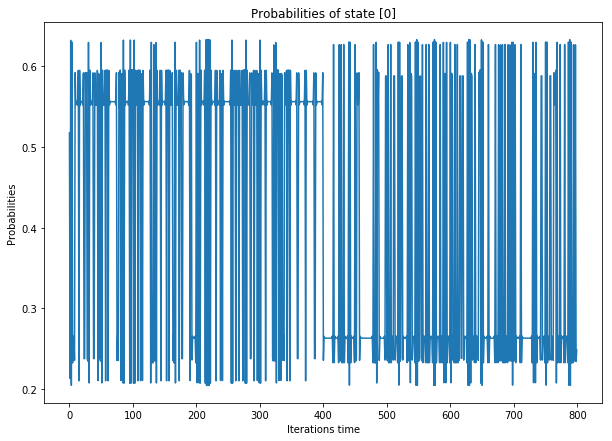

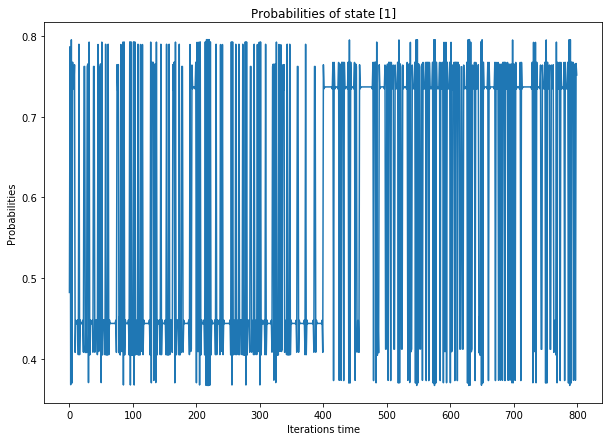

In [79]:
obs_vocab = {'L':0, 'R':1}
numstates = 2
hmm = MyLittleHMM(numstates=numstates, observations_vocab=obs_vocab)

result_mtx = hmm.compute(data)

for s in range(numstates):
    plt.figure(figsize=(10,7))
    plt.plot(result_mtx[s])
    plt.title("Probabilities of state [{}]".format(s))
    plt.xlabel("Iterations time")
    plt.ylabel("Probabilities")
    plt.show()

In [67]:
len(result_mtx[0])

800